# <center>Text to Image Generator</center>
If you want to train the model on more epochs for even better performance, do so on Kaggle by using GPU P100 or the GPU on your system (if any).
# Data Loading and Model Architecture Configurations

In [53]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets
from torchvision.utils import save_image
import os
from PIL import Image
import numpy as np
import json

# Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 64
image_size = 256
nz = 100  # Size of z latent vector
nc = 3    # Number of channels in the images
ngf = 64  # Size of feature maps in generator
ndf = 64  # Size of feature maps in discriminator
num_epochs = 100
lr = 0.0002
beta1 = 0.5
embedding_dim = 100  # Dimension of text embeddings

# Create a dataset
class FloorplanDataset(Dataset):
    def __init__(self, image_dir, tags_dir, transform=None):
        self.image_dir = image_dir
        self.tags_dir = tags_dir
        self.transform = transform
        self.filenames = [f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(tags_dir, f.replace('png', 'txt')))]

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.filenames[idx])
        image = Image.open(img_name).convert('RGB')
        
        tag_name = os.path.join(self.tags_dir, self.filenames[idx].replace('png', 'txt'))
        with open(tag_name, 'r') as file:
            tags = file.read().replace('\n', '')
        
        if self.transform:
            image = self.transform(image)
        
        # Convert tags to embeddings (simple one-hot-like encoding for demonstration)
        tag_embedding = torch.zeros(embedding_dim)
        words = tags.split()
        for word in words:
            index = abs(hash(word)) % embedding_dim
            tag_embedding[index] = 1

        return image, tag_embedding

# Transform for image processing
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# Initialize the dataset
dataset = FloorplanDataset(image_dir='/kaggle/input/floorplan/floorplan_image', tags_dir='/kaggle/input/tags-floors/human_annotated_tags', transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Conditional GAN Model Definition

In [54]:
# Generator Model
class Generator(nn.Module):
    def __init__(self, nz, ngf, nc, embedding_dim):
        super(Generator, self).__init__()
        self.text = nn.Linear(embedding_dim, nz)  # Embedding layer for text
        # Initialize the modules to be used in the generator network.
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(nz * 2, ngf * 16, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 16),
            nn.ReLU(True),
            # state size. (ngf*16) x 4 x 4
            nn.ConvTranspose2d(ngf * 16, ngf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 8 x 8
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 16 x 16
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 32 x 32
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 64 x 64
            nn.ConvTranspose2d(ngf, ngf // 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf // 2),
            nn.ReLU(True),
            # state size. (ngf/2) x 128 x 128
            nn.ConvTranspose2d(ngf // 2, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 256 x 256
        )

    def forward(self, noise, text_embedding):
        # Process the text embedding to produce outputs matching the noise tensor dimensions
        text_embedding = self.text(text_embedding)
        # Ensure that text_embedding has the same total elements as noise for each example in the batch
        text_embedding = text_embedding.view(noise.size(0), nz, 1, 1)  # Correctly reshaping

        # Concatenate noise and text embeddings along channel dimension
        combined_input = torch.cat([noise, text_embedding], 1)
        return self.main(combined_input)

# Discriminator Model
class Discriminator(nn.Module):
    def __init__(self, ndf, nc, image_size, embedding_dim):
        super(Discriminator, self).__init__()
        self.text = nn.Linear(embedding_dim, image_size * image_size)  # Convert text embedding into spatial format
        self.main = nn.Sequential(
            # Input is (nc + 1) x 256 x 256
            nn.Conv2d(nc + 1, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 128 x 128
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 64 x 64
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 32 x 32
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 16 x 16
            nn.Conv2d(ndf * 8, ndf * 16, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 16),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*16) x 8 x 8
            nn.Conv2d(ndf * 16, ndf * 32, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 32),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*32) x 4 x 4
            nn.Conv2d(ndf * 32, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()  # Output a single scalar between 0 and 1
        )

    def forward(self, image, text_embedding):
        # Resize and inject text embedding into the image channel dimension
        text_embedding = self.text(text_embedding).view(-1, 1, image_size, image_size)
        # Concatenate along the channel dimension
        input = torch.cat([image, text_embedding], 1)
        return self.main(input).view(-1)  # Flatten the output to a single dimension per batch

# Evaluation Metrics Computation Functions

In [55]:
import torch
import torch.nn.functional as F
from torchvision.models import inception_v3
import numpy as np
from scipy.linalg import sqrtm

# Initialize Inception model
inception_model = inception_v3(pretrained=True, transform_input=False).to(device)
inception_model.eval()

def calculate_fid(real_imgs, fake_imgs, epsilon=1e-6):
    # Ensure the Inception model is in eval mode and gradients are off
    inception_model.eval()
    with torch.no_grad():
        # Get features from the Inception model, ensure they are detached from the graph and moved to CPU
        real_activations = inception_model(real_imgs).detach().cpu().numpy()
        fake_activations = inception_model(fake_imgs).detach().cpu().numpy()

    # Calculate mean and covariance statistics for real and fake activations
    mu1, sigma1 = real_activations.mean(axis=0), np.cov(real_activations, rowvar=False)
    mu2, sigma2 = fake_activations.mean(axis=0), np.cov(fake_activations, rowvar=False)

    # Adding a small epsilon to the diagonal of covariance matrices to ensure they are positive semi-definite
    sigma1 += np.eye(sigma1.shape[0]) * epsilon
    sigma2 += np.eye(sigma2.shape[0]) * epsilon

    # Calculate the sum of squared differences between the means
    ssdiff = np.sum((mu1 - mu2) ** 2.0)

    # Calculate sqrt of product of covariance matrices
    covmean = sqrtm(sigma1.dot(sigma2))

    # Check for complex numbers resulting from numerical inaccuracies and take the real part
    if np.iscomplexobj(covmean):
        covmean = covmean.real

    # Calculate the Frechet Inception Distance
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

def calculate_inception_score(imgs, n_split=10):
    # Calculate probabilities using inception model
    with torch.no_grad():
        preds = F.softmax(inception_model(imgs), dim=1).detach().cpu().numpy()

    # Split predictions and calculate scores
    scores = []
    n_part = preds.shape[0] // n_split
    for i in range(n_split):
        part = preds[i * n_part:(i + 1) * n_part, :]
        kl_div = part * (np.log(part) - np.log(np.expand_dims(part.mean(axis=0), 0)))
        kl_div = kl_div.sum(axis=1)
        scores.append(np.exp(kl_div.mean()))
    return np.mean(scores)

# Model Training

In [56]:

# Create the generator and discriminator
netG = Generator(nz, ngf, nc, embedding_dim).to(device)
netD = Discriminator(ndf, nc, image_size, embedding_dim).to(device)

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

# Loss function
criterion = nn.BCELoss()

# Noise for input to the generator
fixed_noise = torch.randn(batch_size, nz, 1, 1, device=device)
real_label = 1
fake_label = 0
G_losses = []
D_losses = []
real_acc_list = []
fake_acc_list = []
FID_scores = []
IS_scores = []

# Training Loop
for epoch in range(num_epochs):
    real_correct = 0
    fake_correct = 0
    total_real = 0
    total_fake = 0

    for i, data in enumerate(dataloader, 0):
        # Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ## Train with all-real batch
        netD.zero_grad()
        real_cpu = data[0].to(device)
        batch_size = real_cpu.size(0)
        
        # Apply label smoothing here for the real labels
        real_labels = torch.full((batch_size,), 0.9, dtype=torch.float, device=device)  # Soft labels for real
        fake_labels = torch.full((batch_size,), 0.1, dtype=torch.float, device=device)  # Soft labels for fake

        output = netD(real_cpu, data[1].to(device))
        errD_real = criterion(output, real_labels)
        errD_real.backward()
        D_x = output.mean().item()

        # Calculate real accuracy
        pred_real = output.detach() > 0.5  # True if discriminator thinks image is real
        real_correct += pred_real.sum().item()
        total_real += batch_size

        ## Train with all-fake batch
        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        fake = netG(noise, data[1].to(device))
        output = netD(fake.detach(), data[1].to(device))
        errD_fake = criterion(output, fake_labels)
        errD_fake.backward()
        D_G_z1 = output.mean().item()

        # Calculate fake accuracy
        pred_fake = output.detach() < 0.5  # True if discriminator thinks image is fake
        fake_correct += pred_fake.sum().item()
        total_fake += batch_size

        errD = errD_real + errD_fake
        optimizerD.step()

        D_losses.append(errD.item())

        # Update G network: maximize log(D(G(z)))
        netG.zero_grad()
        output = netD(fake, data[1].to(device))
        errG = criterion(output, real_labels)  # Fake labels are real for generator cost
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        G_losses.append(errG.item())
        
    # Metric calculation every 5 epochs
    if (epoch + 1) % 5 == 0:
        with torch.no_grad():
            # Fetch a batch and separate images and embeddings
            data = next(iter(dataloader))
            real_images, embeddings = data[0].to(device), data[1].to(device)

            # Generate fake images for evaluation
            fake_images = netG(fixed_noise, embeddings).to(device)  # Use the same embeddings for real and fake images

            # Ensure the images are suitable for Inception V3
            real_images_resized = F.interpolate(real_images, size=(299, 299), mode='bilinear', align_corners=False)
            fake_images_resized = F.interpolate(fake_images, size=(299, 299), mode='bilinear', align_corners=False)

            # Calculate FID and IS
            fid = calculate_fid(real_images_resized, fake_images_resized)
            inception_score = calculate_inception_score(fake_images_resized)

            FID_scores.append(fid)
            IS_scores.append(inception_score)
            print(f'Epoch {epoch+1}: FID = {fid}, IS = {inception_score}')


        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

    # Calculate accuracies for the entire epoch
    real_accuracy = real_correct / total_real
    fake_accuracy = fake_correct / total_fake
    real_acc_list.append(real_accuracy)
    fake_acc_list.append(fake_accuracy)
    print(f'Epoch {epoch + 1} Real Accuracy: {real_accuracy:.4f}, Fake Accuracy: {fake_accuracy:.4f}')

    # Check how the generator is doing by saving G's output on fixed_noise
    if (epoch == 0) or ((epoch + 1) % 10 == 0):
        with torch.no_grad():
            fake = netG(torch.randn(35, nz, 1, 1, device=device), torch.randn(batch_size, embedding_dim, device=device)).detach().to(device)
        output_dir = '/kaggle/working/output'
        os.makedirs(output_dir, exist_ok=True)
        save_image(fake, f'/kaggle/working/output/fake_samples_epoch_{epoch}.png', normalize=True)

# Save the final trained model
torch.save(netG.state_dict(), 'generator.pth')
torch.save(netD.state_dict(), 'discriminator.pth')

Epoch 1 Real Accuracy: 0.8624, Fake Accuracy: 0.8301
Epoch 2 Real Accuracy: 0.8718, Fake Accuracy: 0.8848
Epoch 3 Real Accuracy: 0.8853, Fake Accuracy: 0.8953
Epoch 4 Real Accuracy: 0.9273, Fake Accuracy: 0.9553
Epoch 5: FID = 2592.6319022004245, IS = 1.0252434015274048
Epoch 5 Real Accuracy: 0.9173, Fake Accuracy: 0.9286
Epoch 6 Real Accuracy: 0.9273, Fake Accuracy: 0.9713
Epoch 7 Real Accuracy: 0.9303, Fake Accuracy: 0.9353
Epoch 8 Real Accuracy: 0.9750, Fake Accuracy: 0.9845
Epoch 9 Real Accuracy: 0.8651, Fake Accuracy: 0.8524
Epoch 10: FID = 2245.823458496653, IS = 1.0118516683578491
Epoch 10 Real Accuracy: 0.9096, Fake Accuracy: 0.9218
Epoch 11 Real Accuracy: 0.9590, Fake Accuracy: 0.9795
Epoch 12 Real Accuracy: 0.9156, Fake Accuracy: 0.9168
Epoch 13 Real Accuracy: 0.9298, Fake Accuracy: 0.9503
Epoch 14 Real Accuracy: 0.9370, Fake Accuracy: 0.9370
Epoch 15: FID = 2633.2362895842602, IS = 1.212836503982544
Epoch 15 Real Accuracy: 0.9705, Fake Accuracy: 0.9975
Epoch 16 Real Accuracy

# Evaluation Graphs

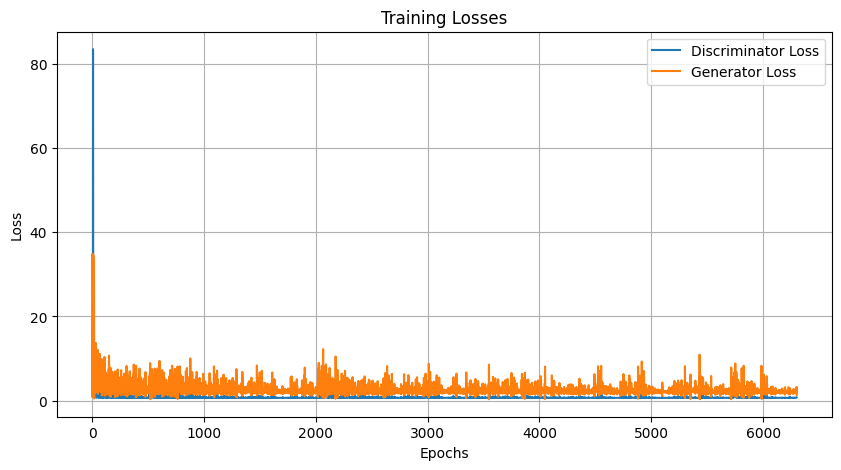

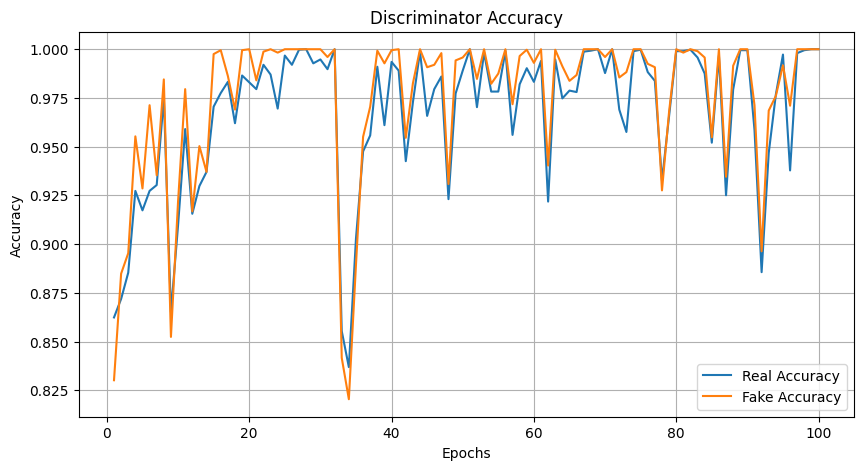

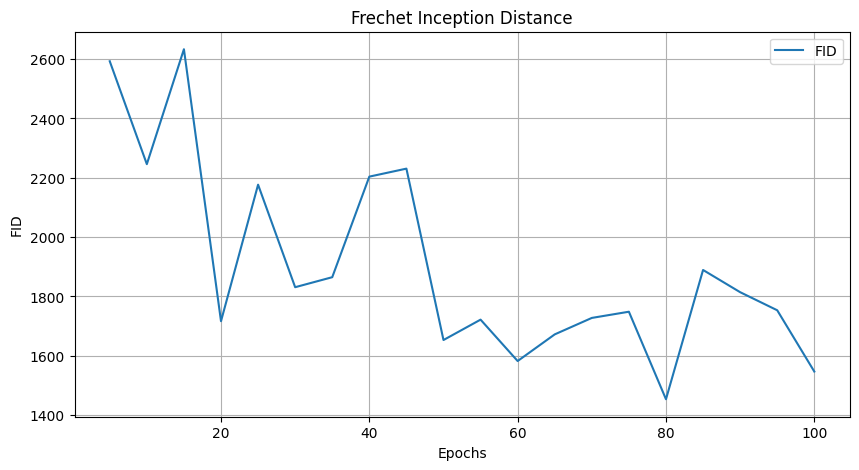

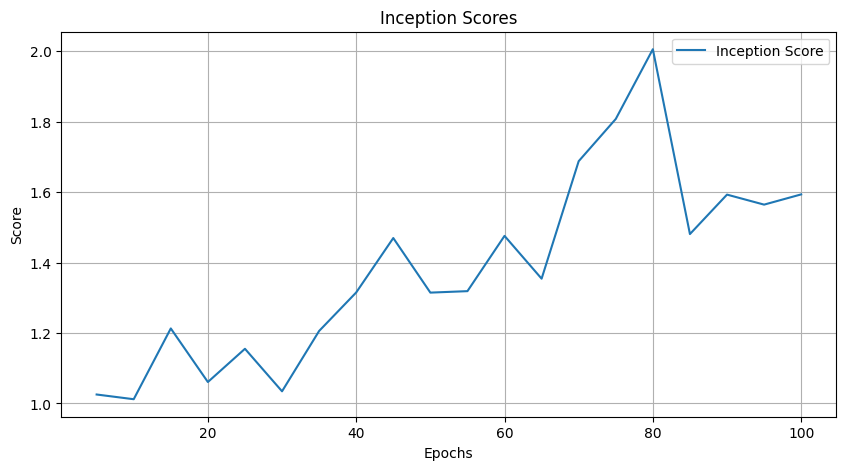

In [59]:
import matplotlib.pyplot as plt

epochs = list(range(1, num_epochs + 1))
metric_epochs = list(range(5, num_epochs + 1, 5))
iterations = list(range(1, len(D_losses) + 1))

# Plotting Discriminator and Generator Losses
plt.figure(figsize=(10, 5))
plt.plot(iterations, D_losses, label='Discriminator Loss')
plt.plot(iterations, G_losses, label='Generator Loss')
plt.title('Training Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plotting Real and Fake Accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs, real_acc_list, label='Real Accuracy')
plt.plot(epochs, fake_acc_list, label='Fake Accuracy')
plt.title('Discriminator Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plotting FID and IS Scores
plt.figure(figsize=(10, 5))
plt.plot(metric_epochs, FID_scores, label='FID')
plt.title('Frechet Inception Distance')
plt.xlabel('Epochs')
plt.ylabel('FID')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(metric_epochs, IS_scores, label='Inception Score')
plt.title('Inception Scores')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()

# Conditional GAN Model Definition and Training
# Generate Images by giving text to the model
Run this code to generate images from your given descriptions of floorplans using the pretrained model in file generator.pth. <br>
Use the inference.ipynb for generating many images.

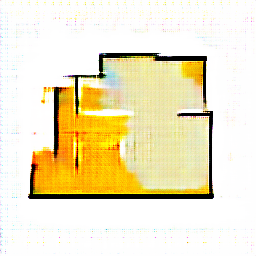

In [60]:
import torchvision.transforms as transforms
from torchvision.utils import save_image
from PIL import Image
import os
from IPython.display import display  # For displaying images in Jupyter notebooks

# Load pre-trained Generator
netG = Generator(nz, ngf, nc, embedding_dim).to(device)
netG.load_state_dict(torch.load('generator.pth', map_location=device))
netG.eval()

# Function to generate an image from text
def generate_image_from_text(text):
    # Convert text to embedding (simplified one-hot encoding as an example)
    tag_embedding = torch.zeros(embedding_dim)
    words = text.split()
    for word in words:
        index = abs(hash(word)) % embedding_dim
        tag_embedding[index] = 1

    # Generate noise vector
    noise = torch.randn(1, nz, 1, 1, device=device)
    tag_embedding = tag_embedding.to(device).unsqueeze(0)  # Add batch dimension

    # Generate image
    with torch.no_grad():
        fake_image = netG(noise, tag_embedding)
    
    # Convert image tensor to PIL Image
    fake_image = (fake_image * 0.5 + 0.5)  # unnormalize
    img = transforms.ToPILImage()(fake_image.squeeze(0).cpu())
    img.save(f'generated_image.png')  # Save the image

    # Display the image
    display(img)

generate_image_from_text("Balcony Room Located on North east corner with master Room on below , Total size of 11 Feet length and 3 Feet Width. bath Room Located on exact south center of the plan with com Room on right , Total size of 7 Feet length and 3 Feet Width. com Room Located on South east corner with master Room on above , Total size of 13 Feet length and 9 Feet Width. Kitchen Room Located on North west corner with balcony Room on right , Total size of 10 Feet length and 2 Feet Width. Living Room Located on covered entire west area with kitchen Room on above , Total size of 20 Feet length and 18 Feet Width. Master Room Located on North east side with balcony Room on above , Total size of 12 Feet length and 12 Feet Width. ")